In [ ]:
!pip install scikeras

In [ ]:
!pip install --upgrade scikit-learn

In [ ]:

# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import mutual_info_classif, chi2, RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, confusion_matrix,
                           classification_report)
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline

# Deep learning components
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, BatchNormalization,
                                   Input, LSTM, RepeatVector, TimeDistributed)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 100)

%matplotlib inline


## 1. Data Loading and Preprocessing

In [ ]:
# Load dataset

# Google Drive file ID
file_id = '1zw3f81IXdsA6GbrqTMs93Q0hmcaxSl4U'

# Direct download link
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Load CSV into DataFrame
df = pd.read_csv(download_url)

print(f"Initial dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

Initial dataset shape: (70692, 22)

First 5 rows:


,Diabetes,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,0,1,26,0,0,0,1,0,1,0,1,0,3,5,30,0,1,4,6,8
1,0,1,1,1,26,1,1,0,0,1,0,0,1,0,3,0,0,0,1,12,6,8
2,0,0,0,1,26,0,0,0,1,1,1,0,1,0,1,0,10,0,1,13,6,8
3,0,1,1,1,28,1,0,0,1,1,1,0,1,0,3,0,3,0,1,11,6,8
4,0,0,0,1,29,1,0,0,1,1,1,0,1,0,2,0,0,0,0,8,5,8


### A. Data Cleaning

In [ ]:

# Handle missing values
print("=== MISSING VALUE HANDLING ===")
print("Missing values per column:")
print(df.isnull().sum())

for col in df.columns:
    if df[col].isnull().sum() > 0:
        print(f"\nImputing missing values for {col}")
        if df[col].dtype in ['int64', 'float64']:
            skewness = df[col].skew()
            if abs(skewness) > 1:  # Highly skewed
                impute_val = df[col].median()
                print(f"Using median ({impute_val}) due to high skewness ({skewness:.2f})")
            else:
                impute_val = df[col].mean()
                print(f"Using mean ({impute_val:.2f})")
            df[col] = df[col].fillna(impute_val)
        else:
            mode_val = df[col].mode()[0]
            print(f"Using mode ({mode_val})")
            df[col] = df[col].fillna(mode_val)

# Handle duplicates
print("\n=== DUPLICATE HANDLING ===")
initial_count = len(df)
df = df.drop_duplicates()
removed_count = initial_count - len(df)
print(f"Removed {removed_count} duplicate rows ({removed_count/initial_count:.2%})")

=== MISSING VALUE HANDLING ===
Missing values per column:
Diabetes                0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

=== DUPLICATE HANDLING ===
Removed 1635 duplicate rows (2.31%)


### B. Feature Engineering

In [ ]:
# Data Conversion - One-Hot Encoding
print("\n=== CATEGORICAL ENCODING ===")
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
if categorical_cols:
    print(f"One-hot encoding for: {categorical_cols}")
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
else:
    print("No categorical columns found for one-hot encoding")

# Normalization/Standardization
print("\n=== FEATURE SCALING ===")
num_cols = [col for col in df.columns
            if df[col].dtype in ['int64','float64']
            and col != 'Diabetes'
            and len(df[col].unique()) > 5]  # Exclude binary features

# Standardize normally distributed features
std_cols = [col for col in num_cols if abs(df[col].skew()) < 1]
if std_cols:
    print(f"Standardizing {len(std_cols)} features:")
    print(std_cols)
    scaler = StandardScaler()
    df[std_cols] = scaler.fit_transform(df[std_cols])

# Normalize other numerical features
minmax_cols = list(set(num_cols) - set(std_cols))
if minmax_cols:
    print(f"\nNormalizing {len(minmax_cols)} features:")
    print(minmax_cols)
    minmax_scaler = MinMaxScaler()
    df[minmax_cols] = minmax_scaler.fit_transform(df[minmax_cols])

print("\nData after preprocessing:")
display(df.head())


=== CATEGORICAL ENCODING ===
No categorical columns found for one-hot encoding

=== FEATURE SCALING ===
Standardizing 3 features:
['Age', 'Education', 'Income']

Normalizing 3 features:
['MentHlth', 'BMI', 'PhysHlth']

Data after preprocessing:


,Diabetes,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,0,1,0.162791,0,0,0,1,0,1,0,1,0,3,0.166667,1.000000,0,1,-1.610781,1.068379,1.079554
1,0,1,1,1,0.162791,1,1,0,0,1,0,0,1,0,3,0.000000,0.000000,0,1,1.188121,1.068379,1.079554
2,0,0,0,1,0.162791,0,0,0,1,1,1,0,1,0,1,0.000000,0.333333,0,1,1.537984,1.068379,1.079554
3,0,1,1,1,0.186047,1,0,0,1,1,1,0,1,0,3,0.000000,0.100000,0,1,0.838258,1.068379,1.079554
4,0,0,0,1,0.197674,1,0,0,1,1,1,0,1,0,2,0.000000,0.000000,0,0,-0.211330,0.096873,1.079554


## 2. Exploratory Data Analysis

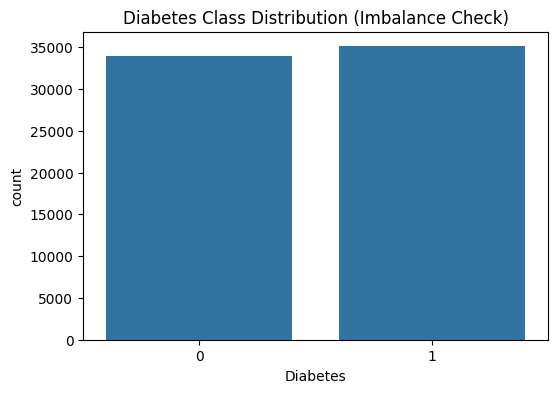

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Diabetes', data=df)
plt.title('Diabetes Class Distribution (Imbalance Check)')
plt.show()

Text(0.5, 1.0, 'Correlation of Top Features with Diabetes')

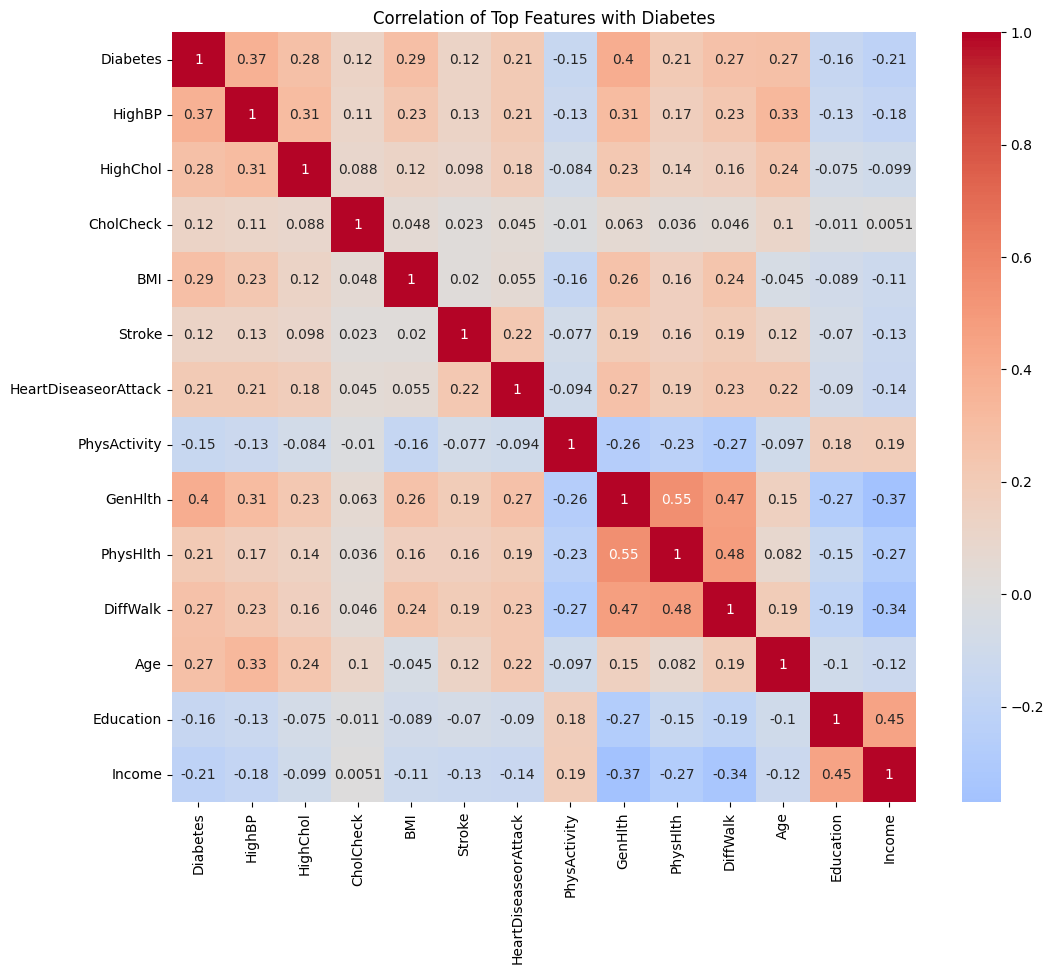

In [ ]:
plt.figure(figsize=(12, 10))
corr = df.corr()
sns.heatmap(corr[abs(corr['Diabetes']) > 0.1].loc[:, abs(corr['Diabetes']) > 0.1],
            annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Top Features with Diabetes')

Text(0.5, 0.98, 'Distribution of Key Continuous Features')

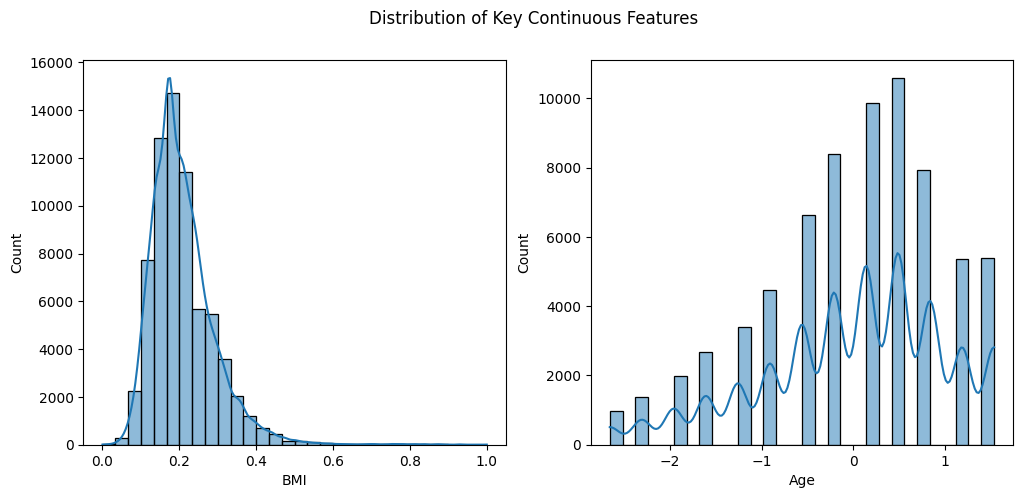

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['BMI'], kde=True, ax=ax[0], bins=30)
sns.histplot(df['Age'], kde=True, ax=ax[1], bins=30)
plt.suptitle('Distribution of Key Continuous Features')

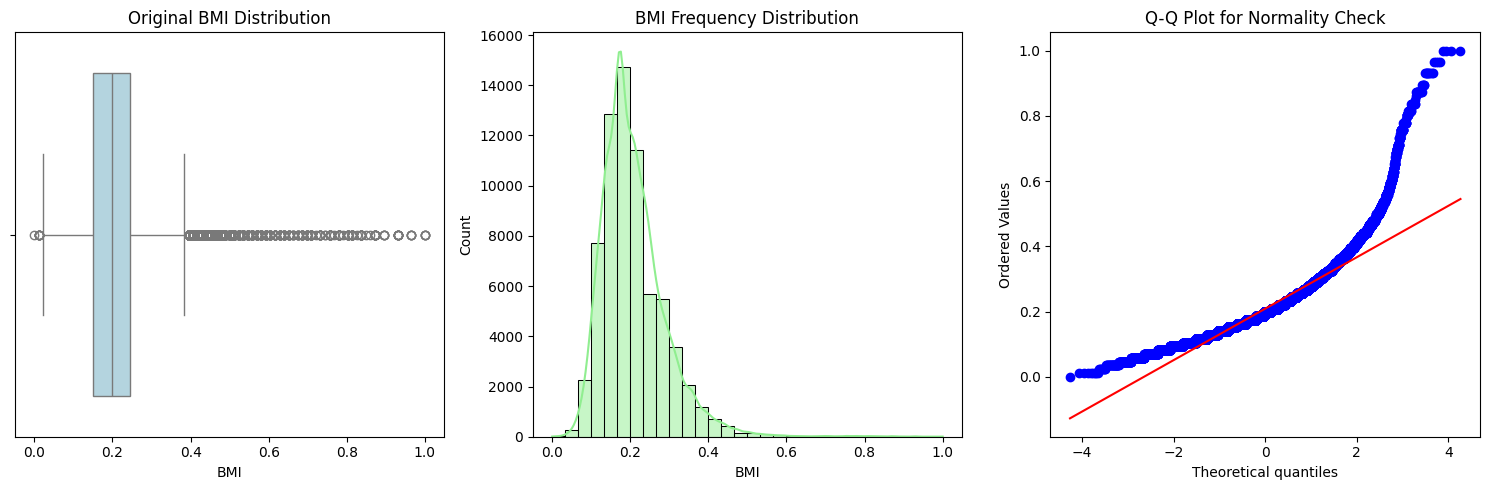

In [ ]:
plt.figure(figsize=(15, 5))

# Boxplot
plt.subplot(1, 3, 1)
sns.boxplot(x=df['BMI'], color='lightblue')
plt.title('Original BMI Distribution')

# Histogram
plt.subplot(1, 3, 2)
sns.histplot(df['BMI'], kde=True, bins=30, color='lightgreen')
plt.title('BMI Frequency Distribution')

# QQ-Plot
plt.subplot(1, 3, 3)
import scipy.stats as stats
stats.probplot(df['BMI'], dist="norm", plot=plt)
plt.title('Q-Q Plot for Normality Check')

plt.tight_layout()
plt.show()

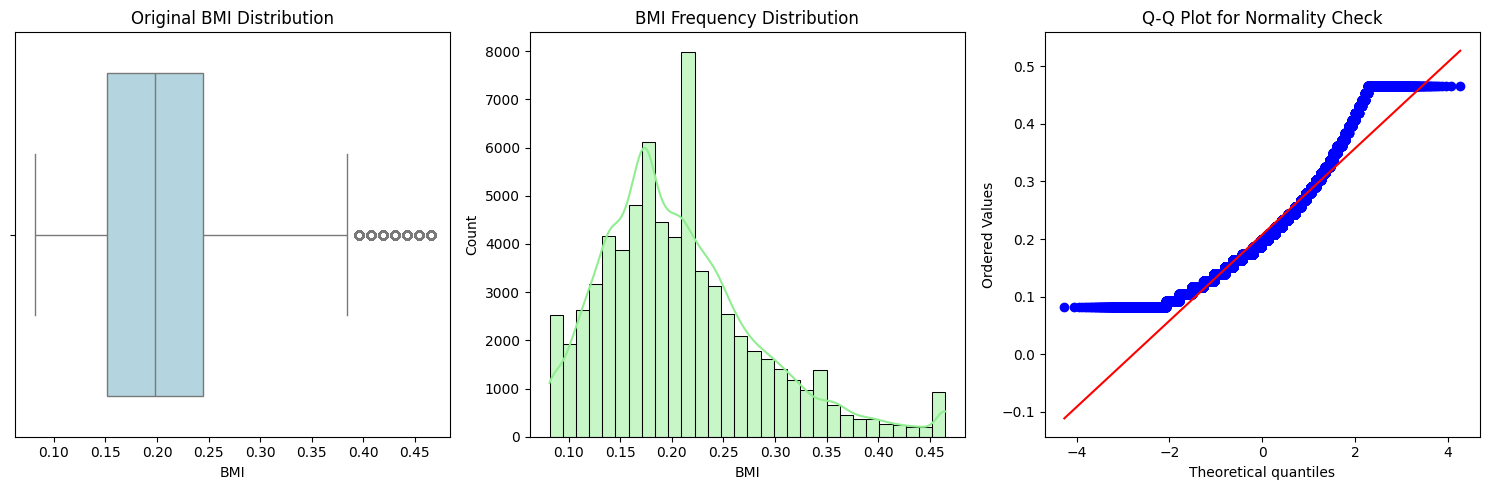

In [ ]:
# STEP 3: Apply Quantile Capping to BMI
lower_threshold = df['BMI'].quantile(0.01)  # 1st percentile
upper_threshold = df['BMI'].quantile(0.99)  # 99th percentile

# Update BMI in-place by clipping outliers
df['BMI'] = df['BMI'].clip(lower=lower_threshold, upper=upper_threshold)
plt.figure(figsize=(15, 5))

# Boxplot
plt.subplot(1, 3, 1)
sns.boxplot(x=df['BMI'], color='lightblue')
plt.title('Original BMI Distribution')

# Histogram
plt.subplot(1, 3, 2)
sns.histplot(df['BMI'], kde=True, bins=30, color='lightgreen')
plt.title('BMI Frequency Distribution')

# QQ-Plot
plt.subplot(1, 3, 3)
import scipy.stats as stats
stats.probplot(df['BMI'], dist="norm", plot=plt)
plt.title('Q-Q Plot for Normality Check')

plt.tight_layout()
plt.show()

Text(0.5, 0.98, 'Impact of Categorical Features on Diabetes')

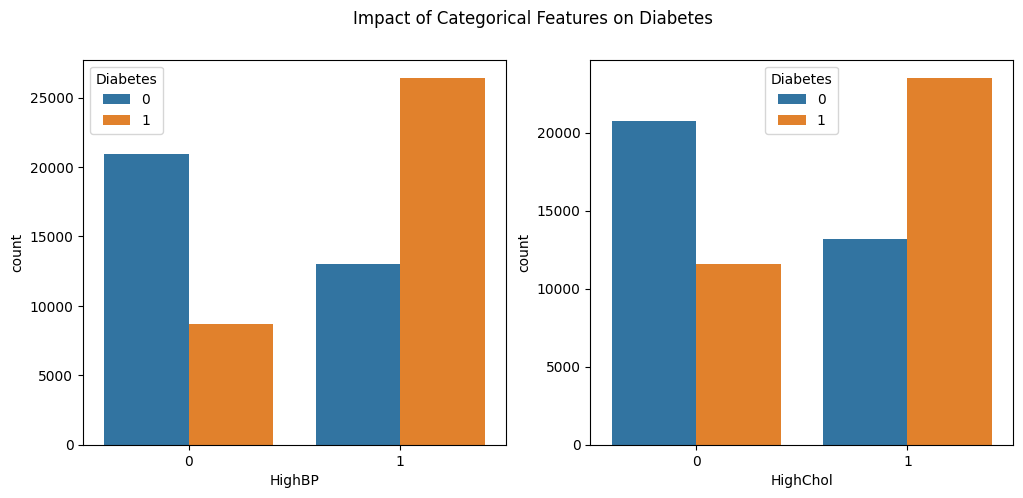

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x='HighBP', hue='Diabetes', data=df, ax=ax[0])
sns.countplot(x='HighChol', hue='Diabetes', data=df, ax=ax[1])
plt.suptitle('Impact of Categorical Features on Diabetes')

## 3. Feature Selection (Top 10 Features)

In [ ]:
X = df.drop('Diabetes', axis=1)
y = df['Diabetes']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

Text(0.5, 0.98, 'Class Balance Before/After SMOTE')

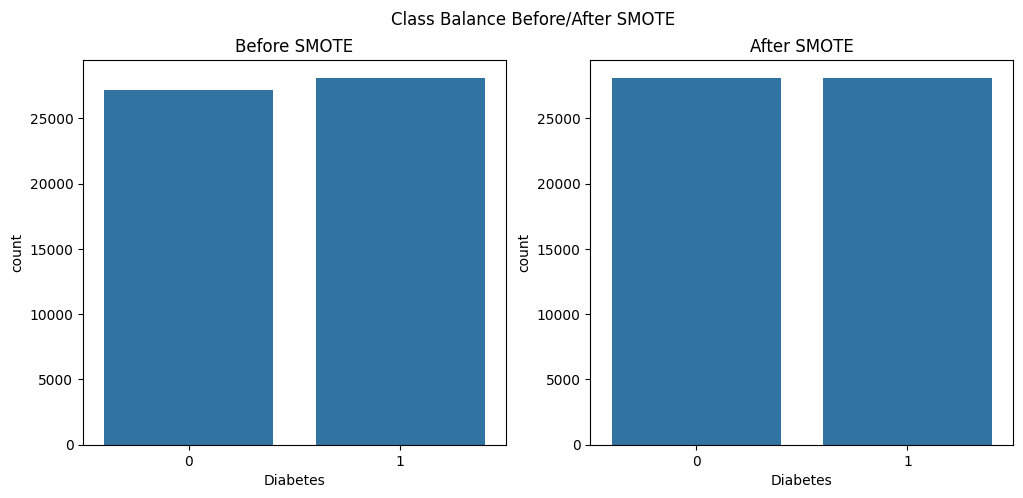

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x=y_train, ax=ax[0]).set_title('Before SMOTE')
sns.countplot(x=y_smote, ax=ax[1]).set_title('After SMOTE')
plt.suptitle('Class Balance Before/After SMOTE')

In [ ]:

# Feature selection methods
def get_top_k_features(scores, features, k=10):
    return [f for _, f in sorted(zip(scores, features), reverse=True)[:k]]

# 1. Filter Method - Mutual Information
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
mi_top10 = get_top_k_features(mi_scores, X.columns, 10)
print("Top 10 Features by Mutual Information:", mi_top10)

# 2. Wrapper Method - RFE with Logistic Regression
rfe_lr = RFE(LogisticRegression(max_iter=1000), n_features_to_select=10)
rfe_lr.fit(X_train, y_train)
rfe_lr_top10 = X.columns[rfe_lr.support_].tolist()
print("\nTop 10 Features by RFE-LR:", rfe_lr_top10)

# 3. Wrapper Method - RFE with Random Forest
rfe_rf = RFE(RandomForestClassifier(), n_features_to_select=10)
rfe_rf.fit(X_train, y_train)
rfe_rf_top10 = X.columns[rfe_rf.support_].tolist()
print("\nTop 10 Features by RFE-RF:", rfe_rf_top10)

# 4. Embedded Method - Lasso
lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)
lasso_top10 = get_top_k_features(np.abs(lasso.coef_), X.columns, 10)
print("\nTop 10 Features by Lasso:", lasso_top10)

Top 10 Features by Mutual Information: ['GenHlth', 'HighBP', 'BMI', 'Age', 'HighChol', 'DiffWalk', 'Income', 'HeartDiseaseorAttack', 'PhysHlth', 'PhysActivity']

Top 10 Features by RFE-LR: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Stroke', 'HeartDiseaseorAttack', 'HvyAlcoholConsump', 'GenHlth', 'Sex', 'Age']

Top 10 Features by RFE-RF: ['HighBP', 'HighChol', 'BMI', 'Fruits', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

Top 10 Features by Lasso: ['BMI', 'CholCheck', 'HighBP', 'HvyAlcoholConsump', 'HighChol', 'GenHlth', 'Age', 'HeartDiseaseorAttack', 'Sex', 'PhysHlth']


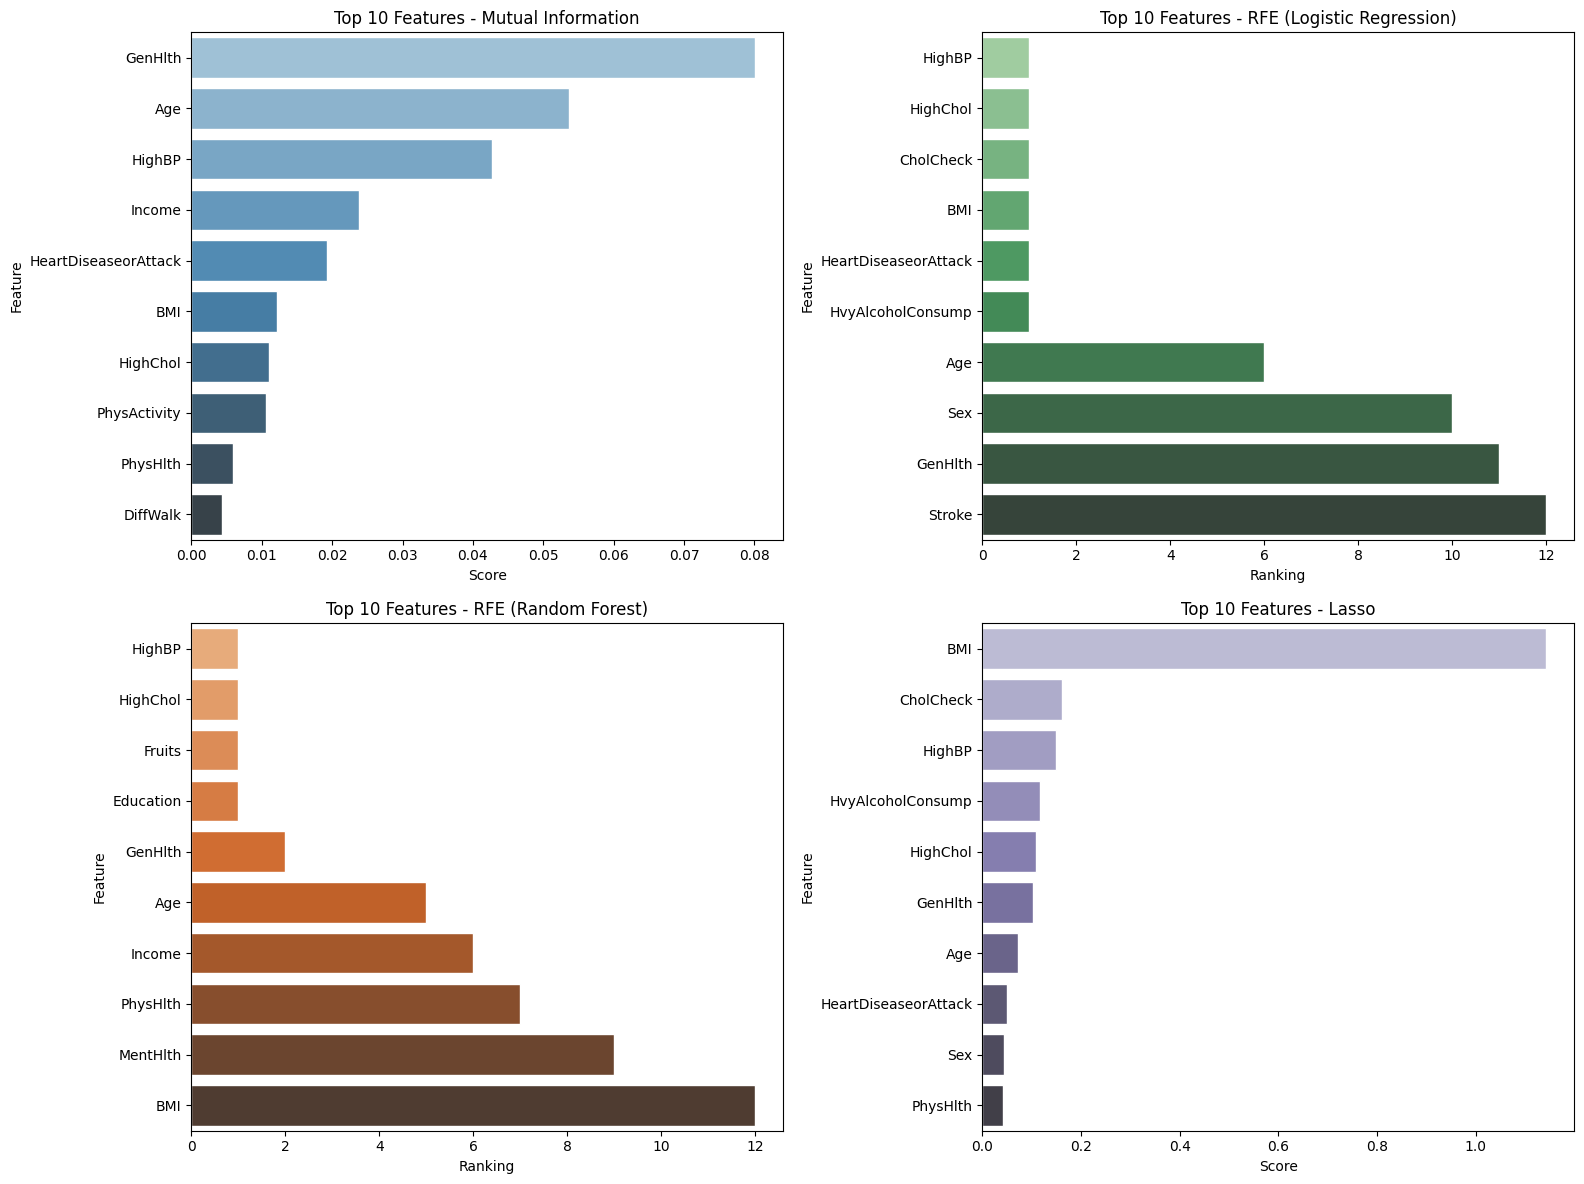

Common features across all selection methods:
{'GenHlth', 'HighChol', 'BMI', 'Age', 'HighBP'}


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X is your DataFrame of features (make sure it is defined before running this)
# Extract the feature names (column names) from the DataFrame
feature_names = X.columns.tolist()  # X is your feature DataFrame

# Get the top 10 features for each method

# 1. Mutual Information - assuming 'mi_top10' and 'mi_scores' are already defined
mi_top10 = mi_top10[:10]
mi_scores = mi_scores[:10]

# 2. RFE - Logistic Regression (rfe_lr)
rfe_lr_top10 = rfe_lr_top10[:10]
rfe_lr_ranking = rfe_lr.ranking_[:10]

# 3. RFE - Random Forest (rfe_rf)
rfe_rf_top10 = rfe_rf_top10[:10]
rfe_rf_ranking = rfe_rf.ranking_[:10]

# 4. Lasso - assuming 'lasso' is your fitted Lasso model
top10_indices = np.argsort(np.abs(lasso.coef_))[-10:]
lasso_top10_scores = np.abs(lasso.coef_[top10_indices])
lasso_top10 = [feature_names[i] for i in top10_indices]

# ---- Create DataFrames for each method ----

# Mutual Information
mi_df = pd.DataFrame({'Feature': mi_top10, 'Score': mi_scores})

# RFE - Logistic Regression
rfe_lr_df = pd.DataFrame({'Feature': rfe_lr_top10, 'Ranking': rfe_lr_ranking})

# RFE - Random Forest
rfe_rf_df = pd.DataFrame({'Feature': rfe_rf_top10, 'Ranking': rfe_rf_ranking})

# Lasso
lasso_df = pd.DataFrame({'Feature': lasso_top10, 'Score': lasso_top10_scores})

# ---- Sort the DataFrames by importance score/ranking ----
mi_df_sorted = mi_df.sort_values(by='Score', ascending=False)
rfe_lr_df_sorted = rfe_lr_df.sort_values(by='Ranking', ascending=True)
rfe_rf_df_sorted = rfe_rf_df.sort_values(by='Ranking', ascending=True)
lasso_df_sorted = lasso_df.sort_values(by='Score', ascending=False)

# ---- Visualization ----
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
sns.set(style='whitegrid')

# Plot 1: Mutual Information - sorted by score
sns.barplot(x='Score', y='Feature', data=mi_df_sorted, ax=axs[0, 0], palette='Blues_d')
axs[0, 0].set_title('Top 10 Features - Mutual Information')

# Plot 2: RFE - Logistic Regression - sorted by ranking (lower rank = higher importance)
sns.barplot(x='Ranking', y='Feature', data=rfe_lr_df_sorted, ax=axs[0, 1], palette='Greens_d')
axs[0, 1].set_title('Top 10 Features - RFE (Logistic Regression)')

# Plot 3: RFE - Random Forest - sorted by ranking (lower rank = higher importance)
sns.barplot(x='Ranking', y='Feature', data=rfe_rf_df_sorted, ax=axs[1, 0], palette='Oranges_d')
axs[1, 0].set_title('Top 10 Features - RFE (Random Forest)')

# Plot 4: Lasso - sorted by score
sns.barplot(x='Score', y='Feature', data=lasso_df_sorted, ax=axs[1, 1], palette='Purples_d')
axs[1, 1].set_title('Top 10 Features - Lasso')

plt.tight_layout()
plt.show()

# Get the feature selection results from earlier
feature_selection_results = {
    'Mutual Information': mi_top10,
    'RFE-LR': rfe_lr_top10,
    'RFE-RF': rfe_rf_top10,
    'Lasso': lasso_top10  # Use 'lasso_top10' instead of 'lasso_top10_features'
}

# Find common features across all methods
common_features = set(mi_top10)
for method, features in feature_selection_results.items():
    common_features.intersection_update(features)

print("Common features across all selection methods:")
print(common_features)


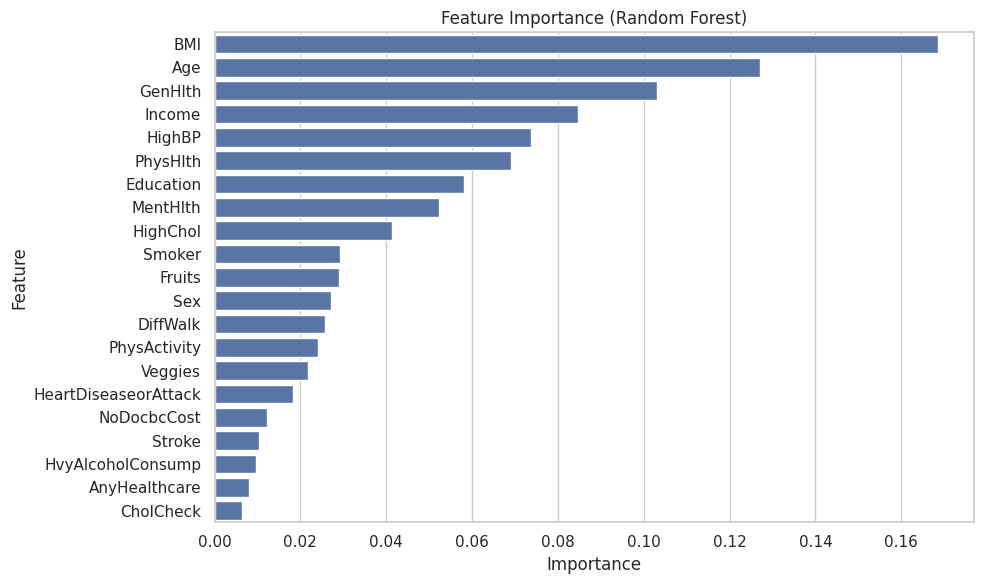

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# Train model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
features = X_train.columns

# Create DataFrame for visualization
feature_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()


In [ ]:
# Get the feature selection results from earlier
feature_selection_results = {
    'Mutual Information': mi_top10,
    'RFE-LR': rfe_lr_top10,
    'RFE-RF': rfe_rf_top10,
    'Lasso': lasso_top10
}

# Find common features across all methods
common_features = set(mi_top10)
for method, features in feature_selection_results.items():
    common_features.intersection_update(features)

print("Common features across all selection methods:")
print(common_features)

Common features across all selection methods:
{'GenHlth', 'HighChol', 'BMI', 'Age', 'HighBP'}


## 4. Model Implementation and Evaluation

In [ ]:
def create_ann(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

def get_ann_model(X):
    input_dim = X.shape[1]
    return KerasClassifier(
        model=create_ann,
        model__input_dim=input_dim,
        epochs=100,
        batch_size=32,
        verbose=0,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
    )

# Evaluation Function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    }

    print(f"\n=== {model_name} Evaluation Metrics ===")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, fmt='d', cmap='Blues',
                cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return metrics


In [ ]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "SVM": SVC(kernel='rbf', probability=True, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "XGBoost": XGBClassifier(scale_pos_weight=sum(y_smote==0)/sum(y_smote==1)),
    "LightGBM": LGBMClassifier(class_weight='balanced'),
    "ANN": get_ann_model  # Function for ANN
}

# Feature sets
feature_sets = {
    'All Features': X_smote.columns.tolist(),
    'Lasso Top10': lasso_top10
}

### All features


EVALUATION WITH ALL FEATURES

=== Logistic Regression (All Features) Evaluation Metrics ===
Accuracy: 0.7451
Precision: 0.7413
Recall: 0.7658
F1: 0.7534
ROC AUC: 0.8183


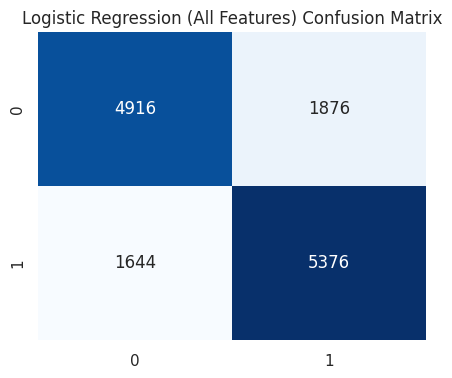


=== SVM (All Features) Evaluation Metrics ===
Accuracy: 0.7430
Precision: 0.7216
Recall: 0.8047
F1: 0.7609
ROC AUC: 0.8144


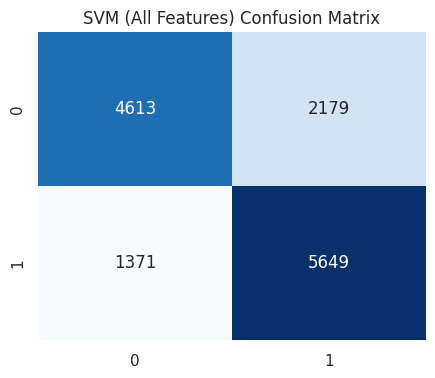


=== Random Forest (All Features) Evaluation Metrics ===
Accuracy: 0.7297
Precision: 0.7175
Recall: 0.7724
F1: 0.7439
ROC AUC: 0.8004


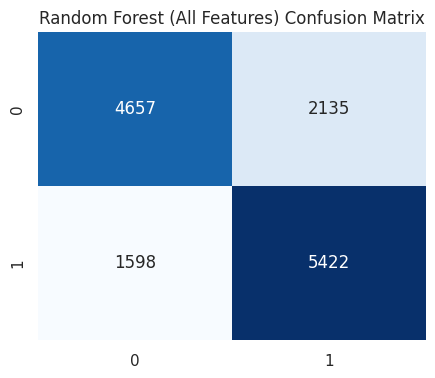


=== XGBoost (All Features) Evaluation Metrics ===
Accuracy: 0.7422
Precision: 0.7285
Recall: 0.7855
F1: 0.7559
ROC AUC: 0.8159


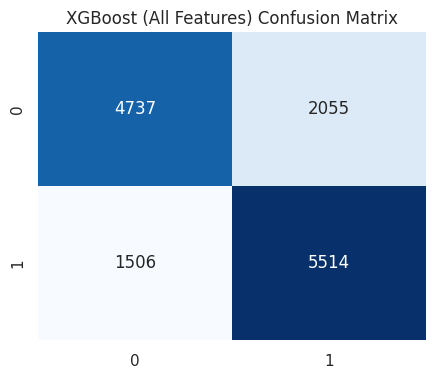

[LightGBM] [Info] Number of positive: 28077, number of negative: 28077
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 56154, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

=== LightGBM (All Features) Evaluation Metrics ===
Accuracy: 0.7501
Precision: 0.7352
Recall: 0.7944
F1: 0.7637
ROC AUC: 0.8238


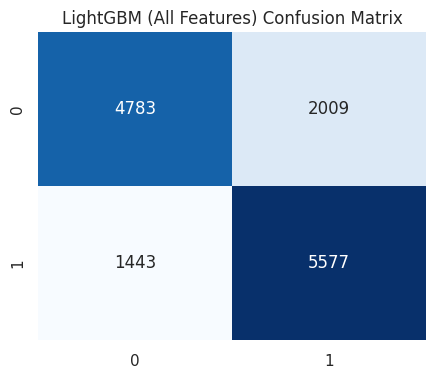


=== ANN (All Features) Evaluation Metrics ===
Accuracy: 0.7462
Precision: 0.7289
Recall: 0.7973
F1: 0.7615
ROC AUC: 0.8192


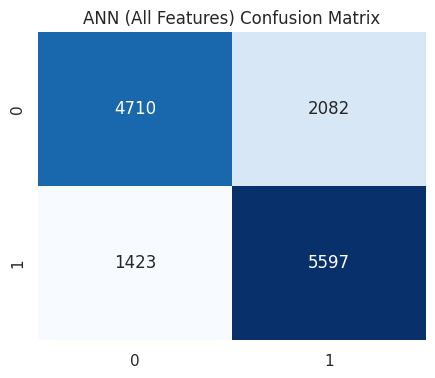

In [ ]:

print("\n" + "="*50)
print("EVALUATION WITH ALL FEATURES")
print("="*50)

all_features_results = {}
X_train_all = X_smote
X_test_all = X_test

for name, model in models.items():
    if name == "ANN":
        model_instance = model(X_train_all)  # Create ANN with correct input dim
    else:
        model_instance = model

    all_features_results[name] = evaluate_model(
        model_instance, X_train_all, X_test_all,
        y_smote, y_test,
        f"{name} (All Features)"
    )

### Lasso Top 10 Features


EVALUATION WITH LASSO TOP10 FEATURES

=== Logistic Regression (Lasso Top10) Evaluation Metrics ===
Accuracy: 0.7422
Precision: 0.7385
Recall: 0.7630
F1: 0.7505
ROC AUC: 0.8167


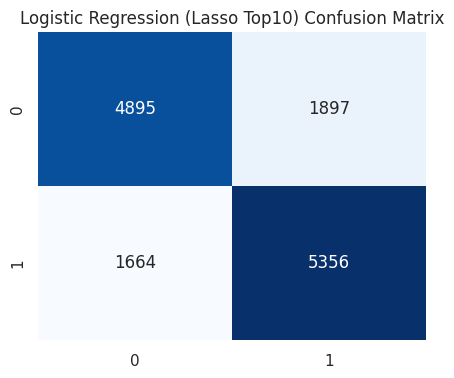


=== SVM (Lasso Top10) Evaluation Metrics ===
Accuracy: 0.7372
Precision: 0.7137
Recall: 0.8063
F1: 0.7572
ROC AUC: 0.8067


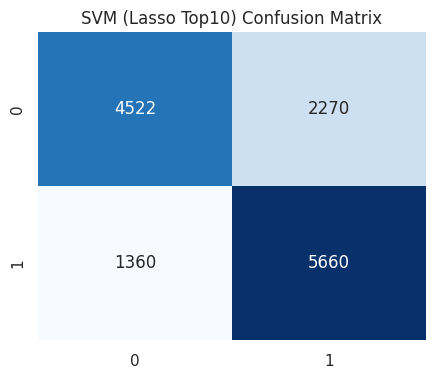


=== Random Forest (Lasso Top10) Evaluation Metrics ===
Accuracy: 0.7081
Precision: 0.7049
Recall: 0.7322
F1: 0.7183
ROC AUC: 0.7703


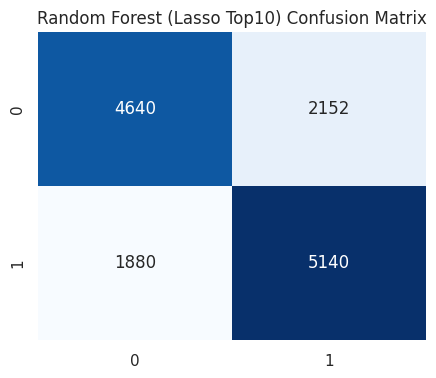


=== XGBoost (Lasso Top10) Evaluation Metrics ===
Accuracy: 0.7388
Precision: 0.7231
Recall: 0.7877
F1: 0.7540
ROC AUC: 0.8151


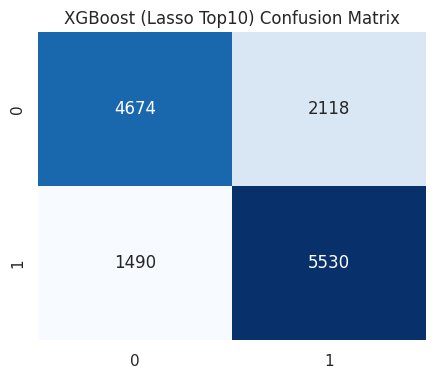

[LightGBM] [Info] Number of positive: 28077, number of negative: 28077
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 56154, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

=== LightGBM (Lasso Top10) Evaluation Metrics ===
Accuracy: 0.7466
Precision: 0.7318
Recall: 0.7915
F1: 0.7605
ROC AUC: 0.8204


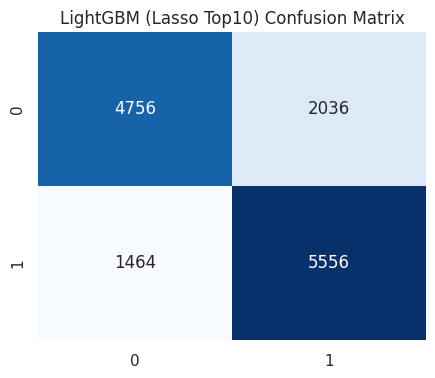


=== ANN (Lasso Top10) Evaluation Metrics ===
Accuracy: 0.7457
Precision: 0.7317
Recall: 0.7887
F1: 0.7592
ROC AUC: 0.8218


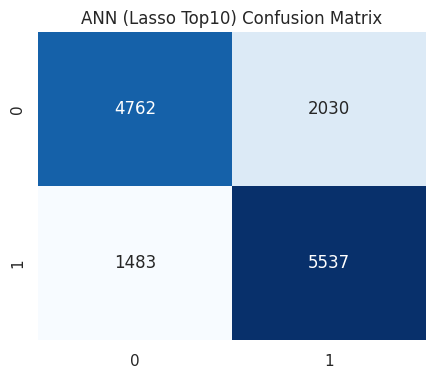

In [ ]:
print("\n" + "="*50)
print("EVALUATION WITH LASSO TOP10 FEATURES")
print("="*50)

lasso_results = {}
X_train_lasso = X_smote[lasso_top10]
X_test_lasso = X_test[lasso_top10]

for name, model in models.items():
    if name == "ANN":
        model_instance = model(X_train_lasso)  # Create ANN with correct input dim
    else:
        model_instance = model

    lasso_results[name] = evaluate_model(
        model_instance, X_train_lasso, X_test_lasso,
        y_smote, y_test,
        f"{name} (Lasso Top10)"
    )


# 5. Results and Comparison


COMPREHENSIVE RESULTS COMPARISON


,All Features Accuracy,All Features Precision,All Features Recall,All Features F1,All Features ROC AUC,Lasso Top10 Accuracy,Lasso Top10 Precision,Lasso Top10 Recall,Lasso Top10 F1,Lasso Top10 ROC AUC
Logistic Regression,0.745149,0.741313,0.765812,0.753363,0.818325,0.742181,0.738453,0.762963,0.750508,0.816741
SVM,0.742977,0.721640,0.804701,0.760911,0.814427,0.737185,0.713745,0.806268,0.757191,0.806718
Random Forest,0.729728,0.717480,0.772365,0.743912,0.800358,0.708080,0.704882,0.732194,0.718278,0.770279
XGBoost,0.742181,0.728498,0.785470,0.755912,0.815883,0.738778,0.723065,0.787749,0.754022,0.815064
LightGBM,0.750072,0.735170,0.794444,0.763659,0.823846,0.746597,0.731823,0.791453,0.760471,0.820361
ANN,0.746235,0.728871,0.797293,0.761548,0.819160,0.745656,0.731730,0.788746,0.759169,0.821803


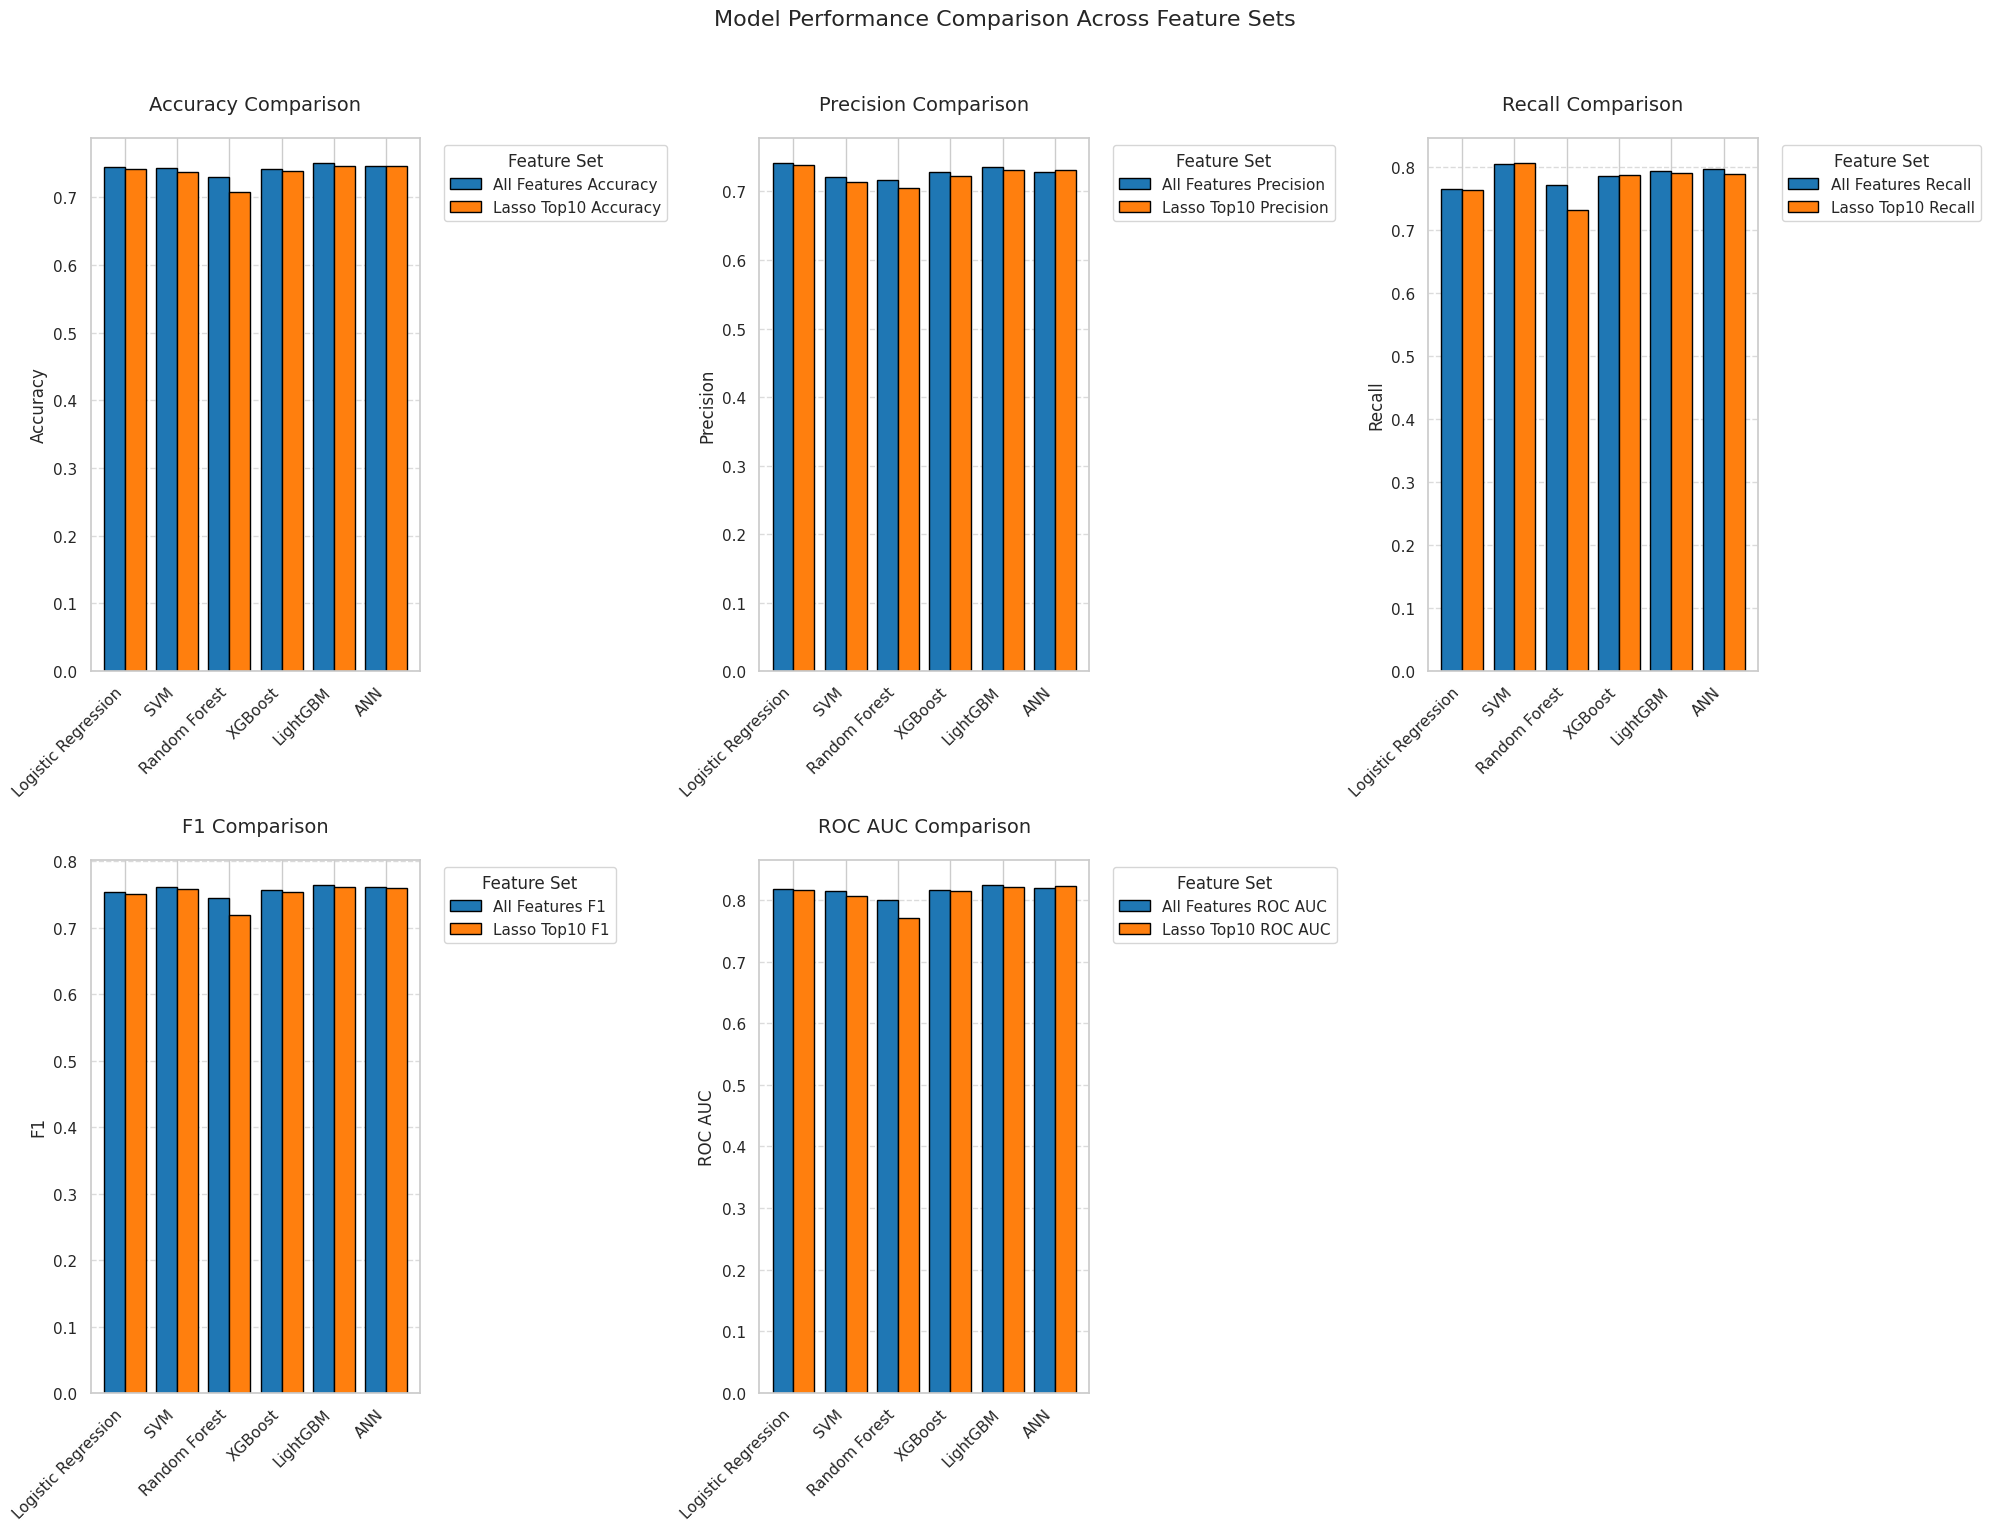


Results saved to 'model_comparison_results.csv' and 'model_comparison_results.xlsx'


In [ ]:
# Compile comprehensive results
comparison_metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']
final_results = pd.DataFrame()

# Combine results from both evaluations
combined_results = {
    'All Features': all_features_results,
    'Lasso Top10': lasso_results
}

for feature_set, model_results in combined_results.items():
    for model_name, metrics in model_results.items():
        for metric in comparison_metrics:
            final_results.loc[model_name, f"{feature_set} {metric}"] = metrics[metric]

print("\n" + "="*50)
print("COMPREHENSIVE RESULTS COMPARISON")
print("="*50)

# Display results with better formatting
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100)
display(final_results)

# Enhanced Visualization
plt.figure(figsize=(20, 15))

# Plot metrics comparison
for i, metric in enumerate(comparison_metrics, 1):
    plt.subplot(2, 3, i)

    # Get columns containing this metric
    metric_cols = [col for col in final_results.columns if metric in col]
    metric_df = final_results[metric_cols]

    # Plot with improved styling
    metric_df.plot(kind='bar', ax=plt.gca(), width=0.8,
                  color=['#1f77b4', '#ff7f0e'], edgecolor='black')

    plt.title(f'{metric} Comparison', fontsize=14, pad=20)
    plt.ylabel(metric, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Feature Set', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Model Performance Comparison Across Feature Sets', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Save results to CSV and Excel
final_results.to_csv('model_comparison_results.csv')
final_results.to_excel('model_comparison_results.xlsx')

print("\nResults saved to 'model_comparison_results.csv' and 'model_comparison_results.xlsx'")